In [1]:
import phd

import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import nengo.utils.numpy as npext
import numpy as np

# Some plotting niceties
phd.plots.setup()

def run_and_plot(model, name, seed):
    net = model.build(net=nengo.Network(seed=seed))
    with net:
        p_traj = nengo.Probe(net.trajectory.output, synapse=0.01)
        p_states = [nengo.Probe(dmp.state[0], synapse=0.01) for dmp in net.syllables]
        p_dmps = [nengo.Probe(dmp.state, synapse=0.01) for dmp in net.syllables]
        p_mem = nengo.Probe(net.memory.output, synapse=0.01)
        p_class = nengo.Probe(net.classifier, synapse=0.01)
        p_resets = [nengo.Probe(dmp.reset, synapse=0.01) for dmp in net.syllables]

    labels = [label.upper() for _, label in freqs]
    simt = 0.0
    tgt_time = []
    for label in labels:
        syllable = model.syllable_dict[label]
        simt += syllable.trajectory.shape[0] * model.trial.dt
        tgt_time.append(simt)

    sim = nengo.Simulator(net)
    sim.run(0.1 + simt)

    # Some analysis
    dmps = np.hstack([sim.data[p_d] for p_d in p_states])
    dmp_labels = np.array([s.label for s in model.syllables])
    memory = nengo.spa.similarity(sim.data[p_mem], net.vocab, True)

    t_ix, class_ix = phd.analysis.classinfo(sim.data[p_class], dmps)
    class_time = sim.trange()[t_ix]
    class_labels = np.array([phd.experiments.path2label(paths[ix]) for ix in class_ix])
    recinfo = [(t, l) for t, l in zip(class_time, class_labels)]
    tgtinfo = [(t, l) for t, l in zip(tgt_time, labels)]
    acc, n_sub, n_del, n_ins = phd.analysis.cl_accuracy(recinfo, tgtinfo)
    tdiff_mean, tdiff_var = phd.analysis.cl_timing(recinfo, tgtinfo)

    tgt_time = np.asarray(tgt_time)
    mem_times = (tgt_time[1:] + tgt_time[:-1]) * 0.5
    mem_ix = (mem_times / model.trial.dt).astype(int)
    mem_class = np.argmax(memory[mem_ix], axis=1)
    slabels = [s.label for s in model.syllables]
    actual = np.array([slabels.index(lbl) for lbl in labels[:-1]])
    memory_acc = np.mean(mem_class == actual)

    print("accuracy: %f" % acc)
    print("subst: %d, del: %d, ins: %d" % (n_sub, n_del, n_ins))
    print("time diff: %f +/- %f" % (tdiff_mean, tdiff_var))
    print("memory acc: %f" % memory_acc)

    # Plotting
    t = sim.trange()
    fig = plt.figure(figsize=(7, 10))

    ax = plt.subplot(6, 1, 1)
    ax.plot(t, sim.data[p_traj])
    ax.set_ylabel("Trajectory input")
    ax.set_xlim(right=t[-1])
    ax.set_xticks(())
    sns.despine(ax=ax)

    for i, (pr, label) in enumerate(zip(p_dmps, labels)):
        ax = plt.subplot(6, 1, i+2)
        ax.plot(t, sim.data[pr][:, 1:], c='0.8')
        ax.plot(t, sim.data[pr][:, 0], c='k')
        ax.set_ylabel("%s iDMP" % label)
        ax.set_xlim(right=t[-1])
        ax.set_xticks(())
        sns.despine(ax=ax)

    ax = plt.subplot(6, 1, 5)
    ax.plot(t, sim.data[p_class])
    ax.set_ylabel("Classifier")
    ax.set_xlim(right=t[-1])
    ax.set_xticks(())
    sns.despine(ax=ax)

    ax = plt.subplot(6, 1, 6)
    ax.plot(t, nengo.spa.similarity(sim.data[p_mem], net.vocab, True))
    ax.set_ylabel("Memory (similarity)")
    ax.set_xlim(right=t[-1])
    ax.legend(labels, loc='best', frameon=True)
    ax.set_xlabel("Time (s)")
    sns.despine(ax=ax)

    fig.tight_layout()
    phd.plots.savefig(fig, 'results', name)

## Basic usage

In [2]:
model = phd.sermo.Recognition()
freqs = [('ges-de-ccv', 'blaa'), ('ges-de-cv', 'tii'), ('ges-de-cvc', 'das')]
paths = []
for gdir, ges in freqs:
    path = phd.ges_path(gdir, '%s.ges' % ges.lower())
    paths.append(path)
    traj = phd.vtl.parse_ges(path).trajectory(dt=model.trial.dt * 2)
    model.add_syllable(label=ges.upper(),
                       trajectory=traj)
model.trial.trajectory = np.vstack([s.trajectory for s in model.syllables])

Building finished in 0:02:22.                                                   
Simulating finished in 0:00:24.                                                 
accuracy: 1.000000
subst: 0, del: 0, ins: 0
time diff: -0.172000 +/- 0.003138
memory acc: 1.000000


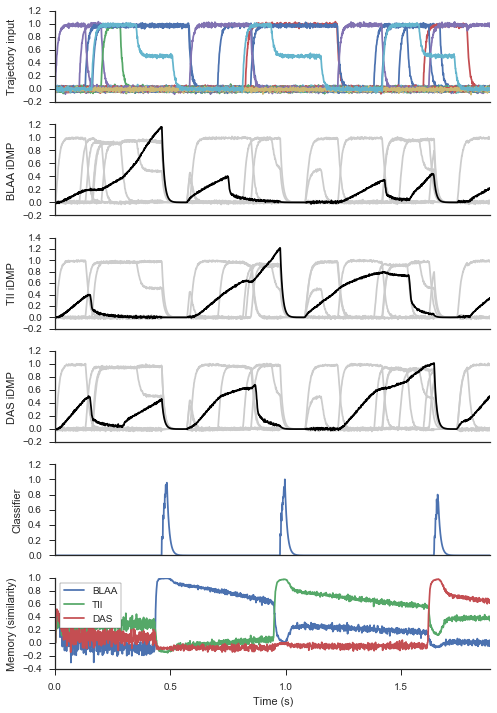

In [3]:
run_and_plot(model, 'recog-good', seed=0)

Building finished in 0:02:24.                                                   
Simulating finished in 0:00:23.                                                 
accuracy: 0.666667
subst: 1, del: 0, ins: 0
time diff: -0.218000 +/- 0.006400
memory acc: 0.500000


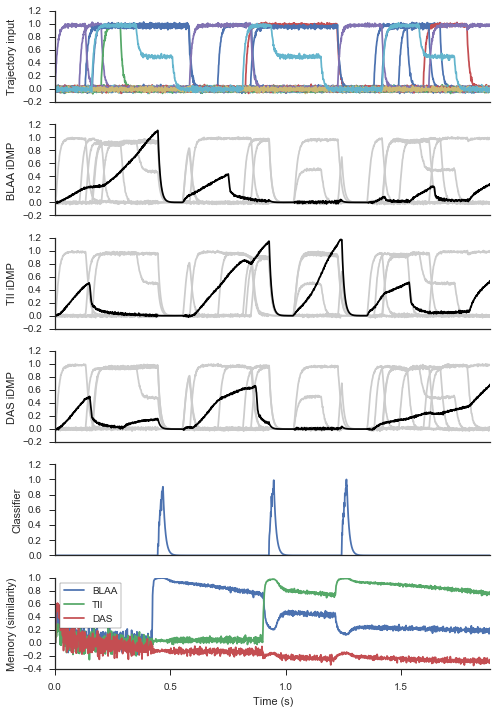

In [4]:
run_and_plot(model, 'recog-bad', seed=3)

## Running an experiment

In [5]:
model = phd.sermo.Recognition()
expt = phd.experiments.RecognitionExperiment(model, n_syllables=3, sequence_len=3)
key = expt.run()
res = phd.experiments.RecognitionResult.load(key)

8feccba46cb2aec4a5a98756cb7419d947bb6bd0.npz not in the cache. Running.


AssertionError: 'freq' attr does not exist

In [ ]:
print("Should be %s" % res.seq)
plt.plot(res.memory)
plt.legend(res.dmp_labels)

In [ ]:
plt.plot(res.dmps);

In [ ]:
print("accuracy: %f" % res.acc)
print("subst: %d, del: %d, ins: %d" % (res.n_sub, res.n_del, res.n_ins))
print("time diff: %f +/- %f" % (res.tdiff_mean, res.tdiff_var))
print("memory acc: %f" % res.memory_acc)

## Plotting experimental results

In [ ]:
phd.plots.recog_time('similarity', 'Similarity threshold');

In [ ]:
phd.plots.recog_time('scale', 'Scale');

In [ ]:
phd.plots.recog_time('syllneurons', 'Syllable neurons');

In [ ]:
phd.plots.recog_time('freq', 'Syllable frequency');

In [ ]:
phd.plots.recog_time('n_syllables', 'Syllabary size', n_syllables=list(range(1, 9)));

In [ ]:
phd.plots.recog_time('sequence_len', 'Sequence length');

In [ ]:
phd.plots.recog_cmp('repeat', 'Repeat syllables', hue_order=['False', 'True']);

## Scaling

In [ ]:
def n_neurons(msg, model, n_syllables):
    net = model.build()
    nn = sum(e.n_neurons for e in net.all_ensembles)
    print("=== %s ===" % msg)

    inneurons = 80 * 48
    amneurons = ((n_syllables * 3) * 50)  # 50 is default for AM
    memneurons = model.cleanup.dimensions * model.memory.neurons_per_dimension
    # Note: depends on gestures per syllable.
    g_per_syll = np.mean([d.state.dimensions - 1 for d in net.syllables])
    print("g per syll: %.3f" % g_per_syll)
    syllneurons = n_syllables * (model.syllable.n_per_d * (g_per_syll + 2) + 20)
    clsneurons = 20

    allneurons = inneurons + amneurons + memneurons + syllneurons + clsneurons

    print("in: %d, spa: %d, syll: %d, cls %d" % (
        inneurons, amneurons + memneurons, syllneurons, clsneurons))

    print("Total: %d neurons" % allneurons)
    print("%.3f mm^3 of cortex" % (allneurons / 27000.))
    print("")

def add_syllables(model, n_syllables):
    model.trial.trajectory = np.zeros((2, 48))
    for p, f in zip(*phd.analysis.get_syllables(n_syllables, 1, 1)):
        tr = phd.vtl.parse_ges(p).trajectory(model.trial.dt)
        lbl = phd.experiments.path2label(p)
        model.add_syllable(label=lbl, freq=f, trajectory=tr)

model = phd.sermo.Recognition()
add_syllables(model, 3)
net = model.build()
n_neurons("Default configuration", model, 3)
model = phd.sermo.Recognition()
model.cleanup.dimensions = 256
add_syllables(model, 3)
net = model.build()
n_neurons("Conservative estimate", model, 1000)
model = phd.sermo.Recognition()
model.cleanup.dimensions = 512
add_syllables(model, 3)
net = model.build()
n_neurons("Generous estimate", model, 2000);